<a href="https://colab.research.google.com/github/curiosity806/machine-learning-and-practice-report/blob/new_try/Dacon_satellite_dist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# 훈련 데이터
!cp '/content/drive/My Drive/2020 Kaggle Study/data/train_final.npy' train.npy

In [3]:
import numpy as np
train = np.load('train.npy')

In [4]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import random
import warnings
import gc
import matplotlib.pyplot as plt


from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

warnings.filterwarnings("ignore")

# 재생산성을 위해 시드 고정
np.random.seed(7)
random.seed(7)
#tf.random.set_seed(7)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 모델링

In [5]:
def mae(y_true, y_pred):
    y_true = np.array(y_true)
    y_true = y_true.reshape(1, -1)[0]  
    y_pred = np.array(y_pred)
    y_pred = y_pred.reshape(1, -1)[0]
    mae = np.mean(np.abs(y_true - y_pred))
    return mae

X = train[:,:14]
y = train[:,-1]
X.shape, y.shape

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Standard Scaling한 데이터 생성

In [6]:
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_train_normalized.shape

(9347, 14)

In [ ]:
train_shuffle = train.copy()
np.random.shuffle(train_shuffle)

In [ ]:
print(f'랜덤한 예측 모델의 mae score : {mae(train_shuffle[:,-1], train[:,-1])}')
print(f'타겟의 평균                  : {np.mean(train[:,-1])}')
print(f'타겟의 분산                  : {np.var(train[:,-1])}')
print(f'타겟의 표준편차              : {np.std(train[:,-1])}')

랜덤한 예측 모델의 mae score : 23.952192306518555
타겟의 평균                  : 41.64913558959961
타겟의 분산                  : 632.9130249023438
타겟의 표준편차              : 25.15776252746582


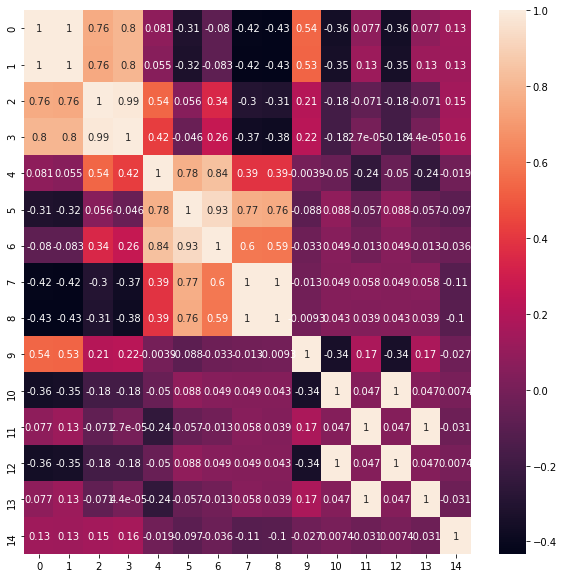

In [ ]:
plt.figure(figsize = (10,10))
train_df = pd.DataFrame(train)
sns.heatmap(train_df.corr(), annot = True)

## 선형회귀

1. 모형의 선형성: 모든 예측값에서 잔차가 비슷하게 있어야 함
2. 잔차의 정규성:Q-Q Plot
3. 잔차의 등분산성
4. 잔차의 독립성

기본 가정을 만족하지 않는다면 stepwise로 4가지 기본 가정을 위배시키는 변수를 제거

<interesting 합니다.>

In [ ]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression

kf = KFold(n_splits=5)
scores = []
for train_index, test_index in kf.split(X_train):
    lr = LinearRegression(normalize = False)
    lr.fit(X_train[train_index], y_train[train_index])
    pred = lr.predict(X_train[test_index])
    scores.append(mae(y_train[test_index], pred))

LR_cv_mae = np.mean(scores)
print('LinearRegression, normalize = False')
print(f'단순 선형 회귀 cv_mae_score = {LR_cv_mae}\n')

kf = KFold(n_splits=5)
scores = []
for train_index, test_index in kf.split(X_train):
    lr = LinearRegression(normalize = True)
    lr.fit(X_train[train_index], y_train[train_index])
    pred = lr.predict(X_train[test_index])
    scores.append(mae(y_train[test_index], pred))
    
LR_normal_cv_mae = np.mean(scores)
print('LinearRegression, normalize = True')
print(f'단순 선형 회귀 cv_mae_score = {LR_normal_cv_mae}\n')

LinearRegression, normalize = False
단순 선형 회귀 cv_mae_score = 17.225513458251953

LinearRegression, normalize = True
단순 선형 회귀 cv_mae_score = 17.225515365600586



## 다항회귀

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

kf = KFold(n_splits=5)
scores = []
for train_index, test_index in kf.split(X_train):
    #다항 항 만들기
    interaction = PolynomialFeatures(degree=3, include_bias=False, interaction_only=True)
    features_interaction = interaction.fit_transform(X_train[train_index])
    test_interaction = interaction.transform(X_train[test_index])
    # 선형회귀 모델 훈련
    lr = LinearRegression(normalize = False)
    lr.fit(features_interaction, y_train[train_index])
    pred = lr.predict(test_interaction)
    scores.append(mae(y_train[test_index], pred))

Poly_LR_cv_mae = np.mean(scores)
print('Poly_LR_cv_mae, degree  = 3,  normalize = False')
print(f'Poly_LR_cv_mae = {Poly_LR_cv_mae}\n')

kf = KFold(n_splits=5)
scores = []
for train_index, test_index in kf.split(X_train):
    #다항 항 만들기
    interaction = PolynomialFeatures(degree=3, include_bias=False, interaction_only=True)
    features_interaction = interaction.fit_transform(X_train[train_index])
    test_interaction = interaction.transform(X_train[test_index])
    # 선형회귀 모델 훈련
    lr = LinearRegression(normalize = True)
    lr.fit(features_interaction, y_train[train_index])
    pred = lr.predict(test_interaction)
    scores.append(mae(y_train[test_index], pred))

Poly_LR_normal_cv_mae = np.mean(scores)
print('Poly_LR_normal_cv_mae, degree  = 3,  normalize = True')
print(f'Poly_LR_normal_cv_mae = {Poly_LR_normal_cv_mae}\n')

Poly_LR_cv_mae, degree  = 3,  normalize = False
Poly_LR_cv_mae = 17.82437515258789

Poly_LR_normal_cv_mae, degree  = 3,  normalize = True
Poly_LR_normal_cv_mae = 17.622615814208984



### 릿지 다항 회귀

In [ ]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import KFold

kf = KFold(n_splits=5)
scores = []
for train_index, test_index in kf.split(X_train):
    #다항 항 만들기
    interaction = PolynomialFeatures(degree=3, include_bias=False, interaction_only=True)
    features_interaction = interaction.fit_transform(X_train[train_index])
    test_interaction = interaction.transform(X_train[test_index])
    # Ridge 모델 훈련
    Ridge_model = Ridge(normalize = False, alpha = 0.1)
    Ridge_model.fit(features_interaction, y_train[train_index])
    pred = Ridge_model.predict(test_interaction)
    scores.append(mae(y_train[test_index], pred))

Poly_Ridge_cv_mae = np.mean(scores)
print('Poly_Ridge_cv_mae, degree  = 3,  normalize = False')
print(f'Poly_Ridge_cv_mae = {Poly_Ridge_cv_mae}\n')

kf = KFold(n_splits=5)
scores = []
for train_index, test_index in kf.split(X_train):
    #다항 항 만들기
    interaction = PolynomialFeatures(degree=3, include_bias=False, interaction_only=True)
    features_interaction = interaction.fit_transform(X_train[train_index])
    test_interaction = interaction.transform(X_train[test_index])
    # Ridge 모델 훈련
    Ridge_model = Ridge(normalize = True, alpha = 0.1)
    Ridge_model.fit(features_interaction, y_train[train_index])
    pred = Ridge_model.predict(test_interaction)
    scores.append(mae(y_train[test_index], pred))

Poly_Ridge_normal_cv_mae = np.mean(scores)
print('Poly_Ridge_normal_cv_mae, degree  = 3,  normalize = True')
print(f'Poly_Ridge_normal_cv_mae = {Poly_Ridge_normal_cv_mae}\n')

Poly_Ridge_cv_mae, degree  = 3,  normalize = False
Poly_Ridge_cv_mae = 19.871604919433594

Poly_Ridge_normal_cv_mae, degree  = 3,  normalize = True
Poly_Ridge_normal_cv_mae = 17.17283821105957



### 라쏘 다항회귀

In [ ]:
kf = KFold(n_splits=5)
scores = []
for train_index, test_index in kf.split(X_train):
    #다항 항 만들기
    interaction = PolynomialFeatures(degree=3, include_bias=False, interaction_only=True)
    features_interaction = interaction.fit_transform(X_train[train_index])
    test_interaction = interaction.transform(X_train[test_index])
    # Ridge 모델 훈련
    Lasso_model = Lasso(normalize = False, alpha = 0.1)
    Lasso_model.fit(features_interaction, y_train[train_index])
    pred = Lasso_model.predict(test_interaction)
    scores.append(mae(y_train[test_index], pred))

Poly_Lasso_cv_mae = np.mean(scores)
print('Poly_Lasso_cv_mae, degree  = 3,  normalize = False')
print(f'Poly_Lasso_cv_mae = {Poly_Lasso_cv_mae}\n')

kf = KFold(n_splits=5)
scores = []
for train_index, test_index in kf.split(X_train):
    #다항 항 만들기
    interaction = PolynomialFeatures(degree=3, include_bias=False, interaction_only=True)
    features_interaction = interaction.fit_transform(X_train[train_index])
    test_interaction = interaction.transform(X_train[test_index])
    # Ridge 모델 훈련
    Lasso_model = Lasso(normalize = True, alpha = 0.1)
    Lasso_model.fit(features_interaction, y_train[train_index])
    pred = Lasso_model.predict(test_interaction)
    scores.append(mae(y_train[test_index], pred))

Poly_Lasso_normal_cv_mae = np.mean(scores)
print('Poly_Lasso_normal_cv_mae, degree  = 3,  normalize = True')
print(f'Poly_Lasso_normal_cv_mae = {Poly_Lasso_normal_cv_mae}\n')

Poly_Lasso_cv_mae, degree  = 3,  normalize = False
Poly_Lasso_cv_mae = 17.052061080932617

Poly_Lasso_normal_cv_mae, degree  = 3,  normalize = True
Poly_Lasso_normal_cv_mae = 17.936939239501953



### 엘라스틱 다항회귀

In [ ]:
kf = KFold(n_splits=5)
scores = []
for train_index, test_index in kf.split(X_train):
    #다항 항 만들기
    interaction = PolynomialFeatures(degree=3, include_bias=False, interaction_only=True)
    features_interaction = interaction.fit_transform(X_train[train_index])
    test_interaction = interaction.transform(X_train[test_index])
    # Ridge 모델 훈련
    ElasticNet_model = ElasticNet(normalize = False, alpha = 0.1)
    ElasticNet_model.fit(features_interaction, y_train[train_index])
    pred = ElasticNet_model.predict(test_interaction)
    scores.append(mae(y_train[test_index], pred))

Poly_ElasticNet_cv_mae = np.mean(scores)
print('Poly_ElasticNet_cv_mae, degree  = 3,  normalize = False')
print(f'Poly_ElasticNet_cv_mae = {Poly_ElasticNet_cv_mae}\n')

kf = KFold(n_splits=5)
scores = []
for train_index, test_index in kf.split(X_train):
    #다항 항 만들기
    interaction = PolynomialFeatures(degree=3, include_bias=False, interaction_only=True)
    features_interaction = interaction.fit_transform(X_train[train_index])
    test_interaction = interaction.transform(X_train[test_index])
    # Ridge 모델 훈련
    ElasticNet_model = ElasticNet(normalize = True, alpha = 0.1)
    ElasticNet_model.fit(features_interaction, y_train[train_index])
    pred = ElasticNet_model.predict(test_interaction)
    scores.append(mae(y_train[test_index], pred))

Poly_ElasticNet_normal_cv_mae = np.mean(scores)
print('Poly_ElasticNet_normal_cv_mae, degree  = 3,  normalize = True')
print(f'Poly_ElasticNet_normal_cv_mae = {Poly_ElasticNet_normal_cv_mae}\n')

Poly_ElasticNet_cv_mae, degree  = 3,  normalize = False
Poly_ElasticNet_cv_mae = 17.051298141479492

Poly_ElasticNet_normal_cv_mae, degree  = 3,  normalize = True
Poly_ElasticNet_normal_cv_mae = 17.936939239501953



## SVM

### 1차 그리드 서치

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR


def mae(y_true, y_pred):
    y_true = np.array(y_true)
    y_true = y_true.reshape(1, -1)[0]  
    y_pred = np.array(y_pred)
    y_pred = y_pred.reshape(1, -1)[0]
    mae = np.mean(np.abs(y_true - y_pred))
    return mae


param_grid = {'C': [0.1,1,10], 'kernel': ['rbf', 'poly', 'sigmoid']}
grid_svr = GridSearchCV(SVR(),
                        param_grid,
                        refit=True,
                        scoring = make_scorer(mae, greater_is_better=False),
                        verbose=2)

grid_svr.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] C=0.1, kernel=rbf ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................ C=0.1, kernel=rbf, total=   4.3s
[CV] C=0.1, kernel=rbf ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.3s remaining:    0.0s


[CV] ................................ C=0.1, kernel=rbf, total=   4.2s
[CV] C=0.1, kernel=rbf ...............................................
[CV] ................................ C=0.1, kernel=rbf, total=   4.2s
[CV] C=0.1, kernel=rbf ...............................................
[CV] ................................ C=0.1, kernel=rbf, total=   4.2s
[CV] C=0.1, kernel=rbf ...............................................
[CV] ................................ C=0.1, kernel=rbf, total=   4.2s
[CV] C=0.1, kernel=poly ..............................................
[CV] ............................... C=0.1, kernel=poly, total=   2.8s
[CV] C=0.1, kernel=poly ..............................................
[CV] ............................... C=0.1, kernel=poly, total=   2.8s
[CV] C=0.1, kernel=poly ..............................................
[CV] ............................... C=0.1, kernel=poly, total=   2.8s
[CV] C=0.1, kernel=poly ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  3.0min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(mae, greater_is_better=False), verbose=2)

In [ ]:
# best parameter 적용
from sklearn.model_selection import KFold

kf = KFold(n_splits=5)
scores = []
for train_index, test_index in kf.split(X_train):
    svr = SVR(C = grid_svr.best_params_['C'],
              kernel = grid_svr.best_params_['kernel'],
              verbose = True)
    svr.fit(X_train[train_index], y_train[train_index])
    pred = svr.predict(X_train[test_index])
    scores.append(mae(y_train[test_index], pred))

SVR_cv_mae = np.mean(scores)
print('\nSVR, C = {0}, kernel = {1}'.format(grid_svr.best_params_['C'], grid_svr.best_params_['kernel']))
print(f'SVR cv_mae_score = {SVR_cv_mae}\n')

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]
SVR, C = 10, kernel = poly
SVR cv_mae_score = 15.837368932183818



In [ ]:
grid_svr.cv_results_['params']

[{'C': 0.1, 'kernel': 'rbf'},
 {'C': 0.1, 'kernel': 'poly'},
 {'C': 0.1, 'kernel': 'sigmoid'},
 {'C': 1, 'kernel': 'rbf'},
 {'C': 1, 'kernel': 'poly'},
 {'C': 1, 'kernel': 'sigmoid'},
 {'C': 10, 'kernel': 'rbf'},
 {'C': 10, 'kernel': 'poly'},
 {'C': 10, 'kernel': 'sigmoid'}]

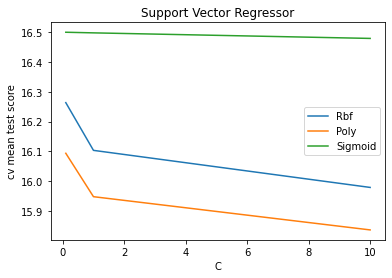

In [ ]:
plt.plot([0.1,1,10], -grid_svr.cv_results_['mean_test_score'][[0,3,6]], label='Rbf')
plt.plot([0.1,1,10], -grid_svr.cv_results_['mean_test_score'][[1,4,7]], label='Poly')
plt.plot([0.1,1,10], -grid_svr.cv_results_['mean_test_score'][[2,5,8]], label='Sigmoid')
plt.legend()
plt.title('Support Vector Regressor')
plt.xlabel('C')
plt.ylabel('cv mean test score')
plt.show()

### 2차 그리드 서치

In [ ]:
param_grid = {'C': range(10,31), 'kernel': ['poly']}
grid_svr = GridSearchCV(SVR(),
                        param_grid,
                        refit=True,
                        scoring = make_scorer(mae, greater_is_better=False),
                        verbose=2)
grid_svr.fit(X_train, y_train)

Fitting 5 folds for each of 21 candidates, totalling 105 fits
[CV] C=10, kernel=poly ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................ C=10, kernel=poly, total=   4.1s
[CV] C=10, kernel=poly ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.1s remaining:    0.0s


[CV] ................................ C=10, kernel=poly, total=   3.8s
[CV] C=10, kernel=poly ...............................................
[CV] ................................ C=10, kernel=poly, total=   3.8s
[CV] C=10, kernel=poly ...............................................
[CV] ................................ C=10, kernel=poly, total=   3.9s
[CV] C=10, kernel=poly ...............................................
[CV] ................................ C=10, kernel=poly, total=   3.7s
[CV] C=11, kernel=poly ...............................................
[CV] ................................ C=11, kernel=poly, total=   3.8s
[CV] C=11, kernel=poly ...............................................
[CV] ................................ C=11, kernel=poly, total=   4.0s
[CV] C=11, kernel=poly ...............................................
[CV] ................................ C=11, kernel=poly, total=   3.8s
[CV] C=11, kernel=poly ...............................................
[CV] .

[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:  7.5min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': range(10, 31), 'kernel': ['poly']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(mae, greater_is_better=False), verbose=2)

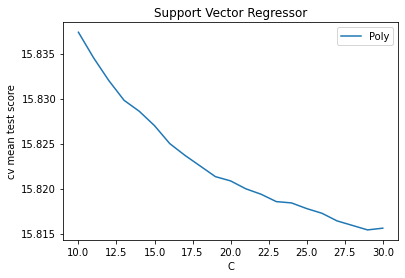

In [ ]:
plt.plot(range(10,31), - grid_svr.cv_results_['mean_test_score'], label='Poly')
plt.legend()
plt.title('Support Vector Regressor')
plt.xlabel('C')
plt.ylabel('cv mean test score')
plt.show()

In [ ]:
print(f'best_score : {-grid_svr.best_score_}')
grid_svr.best_estimator_

best_score : 15.815398319162949


SVR(C=29, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [ ]:
kf = KFold(n_splits=5)
scores = []
for train_index, test_index in kf.split(X_train):
    best_svr = grid_svr.best_estimator_
    best_svr.fit(X_train[train_index], y_train[train_index])
    pred = best_svr.predict(X_train[test_index])
    scores.append(mae(y_train[test_index], pred))

SVR_cv_mae = np.mean(scores)
print('\nSVR, C = {0}, kernel = {1}'.format(grid_svr.best_params_['C'], grid_svr.best_params_['kernel']))
print(f'SVR cv_mae_score = {SVR_cv_mae}\n')


SVR, C = 29, kernel = poly
SVR cv_mae_score = 15.815398319162949



### SVM normalize

In [ ]:
kf = KFold(n_splits=5)
scores = []
for train_index, test_index in kf.split(X_train_normalized):
    best_svr = grid_svr.best_estimator_
    best_svr.fit(X_train_normalized[train_index], y_train[train_index])
    pred = best_svr.predict(X_train_normalized[test_index])
    scores.append(mae(y_train[test_index], pred))

SVR_cv_mae = np.mean(scores)
print('\nSVR, C = {0}, kernel = {1}'.format(grid_svr.best_params_['C'], grid_svr.best_params_['kernel']))
print(f'SVR cv_mae_score = {SVR_cv_mae}\n')


SVR, C = 29, kernel = poly
SVR cv_mae_score = 16.051933968245066



## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer





param_grid = {'max_depth' : range(2,8)}


gs_tree = GridSearchCV(DecisionTreeRegressor(criterion = 'mse'),
                       param_grid,
                       refit=True,
                       scoring = make_scorer(mae, greater_is_better=False),
                       verbose=2)
gs_tree.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.0s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.0s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.0s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.0s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.0s
[CV] max_depth=3 .....................................................
[CV] ...................................... max_depth=3, total=   0.0s
[CV] max_depth=3 .....................................................
[CV] ............

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ...................................... max_depth=3, total=   0.0s
[CV] max_depth=3 .....................................................
[CV] ...................................... max_depth=3, total=   0.0s
[CV] max_depth=3 .....................................................
[CV] ...................................... max_depth=3, total=   0.0s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.0s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.0s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.0s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.0s
[CV] max_depth=4 .....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    1.3s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': range(2, 8)}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False,
             scoring=mak

In [ ]:
# best parameter 적용
kf = KFold(n_splits=5)
scores = []
for train_index, test_index in kf.split(X_train):
    tree = DecisionTreeRegressor(max_depth = gs_tree.best_params_['max_depth'])
    tree.fit(X_train[train_index], y_train[train_index])
    pred = tree.predict(X_train[test_index])
    scores.append(mae(y_train[test_index], pred))

Decision_Tree_cv_mae = np.mean(scores)
print('Decision Tree Regressor, max_depth = {}'.format(gs_tree.best_params_['max_depth']))
print(f'Decision Tree Regressor cv_mae_score = {Decision_Tree_cv_mae}\n')

Decision Tree Regressor, max_depth = 4
Decision Tree Regressor cv_mae_score = 17.573361979662952



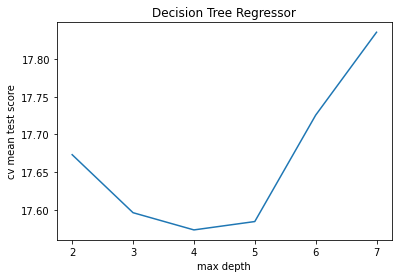

In [ ]:
plt.plot(range(2,8), -gs_tree.cv_results_['mean_test_score'])
plt.title('Decision Tree Regressor')
plt.xlabel('max depth')
plt.ylabel('cv mean test score')
plt.show()

In [ ]:
#normalization 적용
# best parameter 적용
kf = KFold(n_splits=5)
scores = []
for train_index, test_index in kf.split(X_train_normalized):
    tree = gs_tree.best_estimator_
    tree.fit(X_train_normalized[train_index], y_train[train_index])
    pred = tree.predict(X_train_normalized[test_index])
    scores.append(mae(y_train[test_index], pred))

Decision_Tree_cv_mae = np.mean(scores)
print('Decision Tree Regressor, max_depth = {}'.format(gs_tree.best_params_['max_depth']))
print(f'Decision Tree Regressor cv_mae_score = {Decision_Tree_cv_mae}\n')

Decision Tree Regressor, max_depth = 4
Decision Tree Regressor cv_mae_score = 17.573361979662952



## Random Forest
배깅을 적용한 decision tree의 앙상블

In [ ]:
from sklearn.ensemble import RandomForestRegressor

def negative_mae(y_true, y_pred):
    y_true = np.array(y_true)
    y_true = y_true.reshape(1, -1)[0]  
    y_pred = np.array(y_pred)
    y_pred = y_pred.reshape(1, -1)[0]
    mae = np.mean(np.abs(y_true - y_pred))
    return -mae


param_grid = {'max_depth' : range(2,15)}
gs_rf = GridSearchCV(RandomForestRegressor(),
                       param_grid,
                       refit=True,
                       scoring = make_scorer(mae, greater_is_better=False),
                       verbose=2)
gs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 13 candidates, totalling 65 fits
[CV] max_depth=2 .....................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...................................... max_depth=2, total=   1.6s
[CV] max_depth=2 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV] ...................................... max_depth=2, total=   1.6s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   1.5s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   1.6s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   1.6s
[CV] max_depth=3 .....................................................
[CV] ...................................... max_depth=3, total=   2.2s
[CV] max_depth=3 .....................................................
[CV] ...................................... max_depth=3, total=   2.2s
[CV] max_depth=3 .....................................................
[CV] ...................................... max_depth=3, total=   2.2s
[CV] max_depth=3 .....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:  5.4min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n

In [ ]:
# best parameter 적용
kf = KFold(n_splits=5)
scores = []
for train_index, test_index in kf.split(X_train):
    rf = gs_rf.best_estimator_
    rf.fit(X_train[train_index], y_train[train_index])
    pred = rf.predict(X_train[test_index])
    scores.append(mae(y_train[test_index], pred))

Random_Forest_cv_mae = np.mean(scores)
print('Random Forest Regressor, max_depth = {}'.format(gs_rf.best_params_['max_depth']))
print(f'Random Forest Regressor cv_mae_score = {Random_Forest_cv_mae}\n')

Random Forest Regressor, max_depth = 9
Random Forest Regressor cv_mae_score = 17.154415814598075



In [ ]:
kf = KFold(n_splits=5)
scores = []
for train_index, test_index in kf.split(X_train):
    rf = gs_rf.best_estimator_
    rf.fit(X_train_normalized [train_index], y_train[train_index])
    pred = rf.predict(X_train_normalized[test_index])
    scores.append(mae(y_train[test_index], pred))

Random_Forest_cv_mae = np.mean(scores)
print('Random Forest Regressor, max_depth = {}'.format(gs_rf.best_params_['max_depth']))
print(f'Random Forest Regressor Normalization cv_mae_score = {Random_Forest_cv_mae}\n')

Random Forest Regressor, max_depth = 9
Random Forest Regressor Normalization cv_mae_score = 17.171434609067752



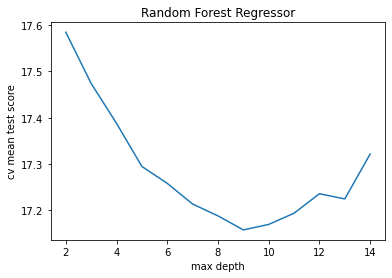

In [ ]:
plt.plot(range(2,15), - gs_rf.cv_results_['mean_test_score'])
plt.title('Random Forest Regressor')
plt.xlabel('max depth')
plt.ylabel('cv mean test score')
plt.show()

feature importance

In [ ]:
# feature_importance: 가장 중요한 feature 인덱스 순으로 정렬
rf = gs_rf.best_estimator_
fi = rf.feature_importances_.tolist()
fi_sort = sorted(fi, reverse=True)

feature_importance = []
for i in range(14):
    feature_importance.append(fi.index(fi_sort[i]))
print('feature_importance : ',feature_importance)
# 중요도 높은 feature 순서대로 선택하여 훈련
cv_mae_selected = []
for i in tqdm(range(1,15)):
    X_train_selected = X_train[:,feature_importance[:i]]
    kf = KFold(n_splits=5)
    scores = []
    for train_index, test_index in kf.split(X_train_selected):
        rf = gs_rf.best_estimator_
        rf.fit(X_train_selected[train_index], y_train[train_index])
        pred = rf.predict(X_train_selected[test_index])
        scores.append(mae(y_train[test_index], pred))
    cv_mae = np.mean(scores)
    cv_mae_selected.append(cv_mae)

  0%|          | 0/14 [00:00<?, ?it/s]

feature_importance :  [0, 4, 3, 1, 2, 13, 12, 8, 11, 10, 5, 7, 6, 9]


100%|██████████| 14/14 [03:49<00:00, 16.42s/it]


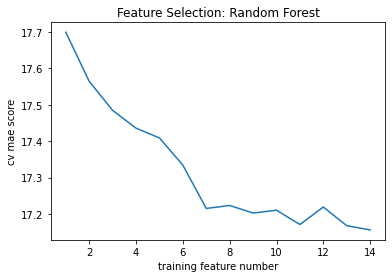

In [ ]:
# feature selection 시각화
plt.plot(range(1,15), cv_mae_selected)
plt.title('Feature Selection: Random Forest')
plt.xlabel('training feature number')
plt.ylabel('cv mae score')
plt.show()

## Gradient Boosting Regressor
부스팅을 적용한 decision tree의 앙상블

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

param_grid = {'max_depth': range(2,10),
              'learning_rate': [0.05, .1]}
gs_gbr = GridSearchCV(GradientBoostingRegressor(),
                      param_grid,
                      refit=True,
                       scoring = make_scorer(mae, greater_is_better=False),
                       verbose=2)
gs_gbr.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] learning_rate=0.05, max_depth=2 .................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................. learning_rate=0.05, max_depth=2, total=   2.4s
[CV] learning_rate=0.05, max_depth=2 .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s


[CV] .................. learning_rate=0.05, max_depth=2, total=   2.5s
[CV] learning_rate=0.05, max_depth=2 .................................
[CV] .................. learning_rate=0.05, max_depth=2, total=   2.4s
[CV] learning_rate=0.05, max_depth=2 .................................
[CV] .................. learning_rate=0.05, max_depth=2, total=   2.4s
[CV] learning_rate=0.05, max_depth=2 .................................
[CV] .................. learning_rate=0.05, max_depth=2, total=   2.4s
[CV] learning_rate=0.05, max_depth=3 .................................
[CV] .................. learning_rate=0.05, max_depth=3, total=   3.5s
[CV] learning_rate=0.05, max_depth=3 .................................
[CV] .................. learning_rate=0.05, max_depth=3, total=   3.5s
[CV] learning_rate=0.05, max_depth=3 .................................
[CV] .................. learning_rate=0.05, max_depth=3, total=   3.5s
[CV] learning_rate=0.05, max_depth=3 .................................
[CV] .

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  8.3min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_no_change=None,
              

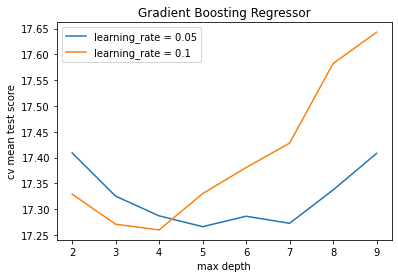

In [ ]:
plt.plot(range(2,10), -gs_gbr.cv_results_['mean_test_score'][:8], label = 'learning_rate = 0.05')
plt.plot(range(2,10), -gs_gbr.cv_results_['mean_test_score'][8:], label = 'learning_rate = 0.1')
plt.legend()

plt.title('Gradient Boosting Regressor')
plt.xlabel('max depth')
plt.ylabel('cv mean test score')
plt.show()

In [ ]:
# best parameter 적용

kf = KFold(n_splits=5)
scores = []

for train_index, test_index in kf.split(X_train):
    gbr = GradientBoostingRegressor(max_depth = gs_gbr.best_params_['max_depth'], learning_rate = gs_gbr.best_params_['learning_rate'])
    gbr.fit(X_train[train_index], y_train[train_index])
    pred = gbr.predict(X_train[test_index])
    scores.append(mae(y_train[test_index], pred))

GBR_cv_mae = np.mean(scores)
print('Gradient Boosting Regressor, max_depth = {0}, learning_rate = {1}'.format(gs_gbr.best_params_['max_depth'], gs_gbr.best_params_['learning_rate']))
print(f'Gradient Boosting Regressor cv_mae_score = {GBR_cv_mae}\n')

Gradient Boosting Regressor, max_depth = 4, learning_rate = 0.1
Gradient Boosting Regressor cv_mae_score = 17.259050469584203



In [ ]:
kf = KFold(n_splits=5)
scores = []

for train_index, test_index in kf.split(X_train):
    gbr = GradientBoostingRegressor(max_depth = gs_gbr.best_params_['max_depth'], learning_rate = gs_gbr.best_params_['learning_rate'])
    gbr.fit(X_train_normalized[train_index], y_train[train_index])
    pred = gbr.predict(X_train_normalized[test_index])
    scores.append(mae(y_train[test_index], pred))

GBR_cv_mae = np.mean(scores)
print('Gradient Boosting Regressor, max_depth = {0}, learning_rate = {1}'.format(gs_gbr.best_params_['max_depth'], gs_gbr.best_params_['learning_rate']))
print(f'Gradient Boosting Regressor Normalization cv_mae_score = {GBR_cv_mae}\n')

Gradient Boosting Regressor, max_depth = 4, learning_rate = 0.1
Gradient Boosting Regressor Normalization cv_mae_score = 17.260200769565962



## feature selection

### Random Forest feature selection

### Gradient Boosting feature selection

In [ ]:
# feature_importance: 가장 중요한 feature 인덱스 순으로 정렬
gbr = gs_gbr.best_estimator_
gbr.fit(X_train, y_train)
fi = gbr.feature_importances_.tolist()
fi_sort = sorted(fi, reverse=True)
feature_importance = []
for i in range(14):
    feature_importance.append(fi.index(fi_sort[i]))

# 중요도 높은 feature 순서대로 선택하여 훈련
cv_mae_selected = []
for i in tqdm(range(1,15)): 
    X_train_selected = X_train[:,feature_importance[:i]]
    kf = KFold(n_splits=5)
    scores = []
    for train_index, test_index in kf.split(X_train_selected):
        gbr = gs_gbr.best_estimator_
        gbr.fit(X_train_selected[train_index], y_train[train_index])
        pred = gbr.predict(X_train_selected[test_index])
        scores.append(mae(y_train[test_index], pred))
        
    cv_mae = np.mean(scores)
    cv_mae_selected.append(cv_mae)

100%|██████████| 14/14 [03:07<00:00, 13.41s/it]


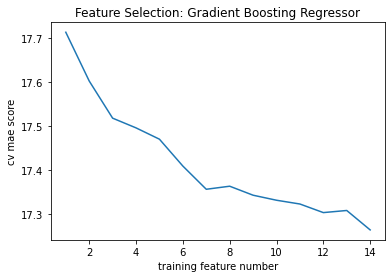

In [ ]:
# feature selection 시각화
plt.plot(range(1,15), cv_mae_selected)
plt.title('Feature Selection: Gradient Boosting Regressor')
plt.xlabel('training feature number')
plt.ylabel('cv mae score')
plt.show()

## XGBoost

### 1차 그리드 서치

In [7]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

xgb = XGBRegressor()
parameters = {'nthread':[4],
              'objective':['reg:linear'], 
              'learning_rate': [.03, 0.05, .1],
              'max_depth': [5, 6, 7, 8, 9, 10],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb,
                        parameters,
                        cv = 3,
                        #n_jobs = 5,
                        scoring = make_scorer(mae, greater_is_better=False),
                        n_jobs = -1,
                        verbose=True)

xgb_grid.fit(X_train, y_train)
# print(xgb_grid.best_score_)
# print(xgb_grid.best_params_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  5.4min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_...
             iid='deprecated', n_jobs=-1,
             param_grid={'colsample_bytree': [0.7],
                         'learning_rate': [0.03, 0.05, 0.1],
                         'max_depth': [5, 6, 7, 8, 9, 10],
                         'min_child_weight': [4], 'n_estimators': [500],
                         'nthread': [4

In [ ]:
# best parameter 적용
from sklearn.model_selection import KFold

kf = KFold(n_splits=5)
scores = []
for train_index, test_index in kf.split(X_train):
    xgb = xgb_grid.best_estimator_
    xgb.fit(X_train[train_index], y_train[train_index])
    pred = xgb.predict(X_train[test_index])
    scores.append(mae(y_train[test_index], pred))

XGB_cv_mae = np.mean(scores)
print('XGBoost, learning_rate = {0}, max_depth = {1}'.format(xgb_grid.best_params_['learning_rate'], xgb_grid.best_params_['max_depth']))
print(f'XGBoost cv_mae_score = {XGB_cv_mae}\n')

XGBoost, learning_rate = 0.03, max_depth = 5
XGBoost cv_mae_score = 17.110212326049805



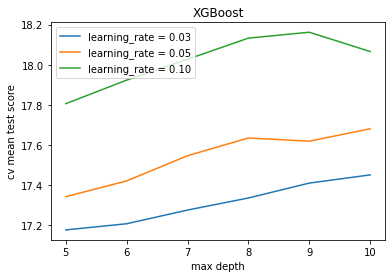

In [8]:
plt.plot([5, 6, 7, 8, 9, 10], -xgb_grid.cv_results_['mean_test_score'][:6], label='learning_rate = 0.03')
plt.plot([5, 6, 7, 8, 9, 10], -xgb_grid.cv_results_['mean_test_score'][6:12], label='learning_rate = 0.05')
plt.plot([5, 6, 7, 8, 9, 10], -xgb_grid.cv_results_['mean_test_score'][12:18], label='learning_rate = 0.10')

plt.legend()
plt.title('XGBoost')
plt.xlabel('max depth')
plt.ylabel('cv mean test score')
plt.show()

### 2차 그리드 서치

In [ ]:
xgb = XGBRegressor()
parameters = {'nthread':[4],
              'objective':['reg:linear'], # reg:squarederror라고 warning 뜨지만 잘만 돌아감 ㅎㅎ
              'learning_rate': [.03],
              'max_depth': range(1,10),
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [400,500,600]
              }

xgb_grid = GridSearchCV(xgb,
                        parameters,
                        cv = 3,
                        scoring = make_scorer(mae, greater_is_better=False),
                        n_jobs = -1,
                        verbose=True)

xgb_grid.fit(X_train, y_train)
# print(xgb_grid.best_score_)
# print(xgb_grid.best_params_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:  5.4min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_...
             iid='deprecated', n_jobs=-1,
             param_grid={'colsample_bytree': [0.7], 'learning_rate': [0.03],
                         'max_depth': range(1, 10), 'min_child_weight': [4],
                         'n_estimators': [400, 500, 600], 'nthread': [4],
                         'objective': ['reg:linear'], '

In [ ]:
xgb = xgb_grid.best_estimator_
xgb

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0,
             importance_type='gain', learning_rate=0.03, max_delta_step=0,
             max_depth=5, min_child_weight=4, missing=None, n_estimators=400,
             n_jobs=1, nthread=4, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=1,
             subsample=0.7, verbosity=1)

In [ ]:
-xgb_grid.best_score_

17.157804489135742

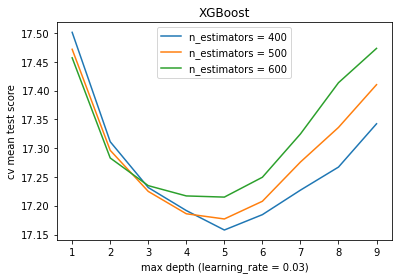

In [ ]:
plt.plot(range(1,10), -xgb_grid.cv_results_['mean_test_score'][range(0,27,3)], label='n_estimators = 400')
plt.plot(range(1,10), -xgb_grid.cv_results_['mean_test_score'][range(1,28,3)], label='n_estimators = 500')
plt.plot(range(1,10), -xgb_grid.cv_results_['mean_test_score'][range(2,29,3)], label='n_estimators = 600')
plt.legend()
plt.title('XGBoost')
plt.xlabel('max depth (learning_rate = 0.03)')
plt.ylabel('cv mean test score')
plt.show()

In [ ]:
xgb_grid.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.03,
 'max_depth': 5,
 'min_child_weight': 4,
 'n_estimators': 400,
 'nthread': 4,
 'objective': 'reg:linear',
 'silent': 1,
 'subsample': 0.7}

In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5)
scores = []
for train_index, test_index in kf.split(X_train):
    xgb = xgb_grid.best_estimator_
    xgb.fit(X_train[train_index], y_train[train_index])
    pred = xgb.predict(X_train[test_index])
    scores.append(mae(y_train[test_index], pred))

XGB_cv_mae = np.mean(scores)
print('XGBoost, learning_rate = {0}, max_depth = {1}, n_estimators = {2}'.format(xgb_grid.best_params_['learning_rate'],
                                                                                 xgb_grid.best_params_['max_depth'],
                                                                                 xgb_grid.best_params_['n_estimators']))
print(f'XGBoost cv_mae_score = {XGB_cv_mae}\n')

XGBoost, learning_rate = 0.03, max_depth = 5, n_estimators = 400
XGBoost cv_mae_score = 17.085966110229492



In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5)
scores = []
for train_index, test_index in kf.split(X_train_normalized):
    xgb = xgb_grid.best_estimator_
    xgb.fit(X_train_normalized[train_index], y_train[train_index])
    pred = xgb.predict(X_train_normalized[test_index])
    scores.append(mae(y_train[test_index], pred))

XGB_cv_mae = np.mean(scores)
print('XGBoost, learning_rate = {0}, max_depth = {1}, n_estimators = {2}'.format(xgb_grid.best_params_['learning_rate'],
                                                                                 xgb_grid.best_params_['max_depth'],
                                                                                 xgb_grid.best_params_['n_estimators']))
print(f'XGBoost Normalization cv_mae_score = {XGB_cv_mae}\n')

XGBoost, learning_rate = 0.03, max_depth = 5, n_estimators = 400
XGBoost Normalization cv_mae_score = 17.08957862854004



In [ ]:
# feature_importance: 가장 중요한 feature 인덱스 순으로 정렬
xgb = xgb_grid.best_estimator_

xgb.fit(X_train, y_train)
fi = xgb.feature_importances_.tolist()
fi_sort = sorted(fi, reverse=True)
feature_importance = []
for i in range(14):
    feature_importance.append(fi.index(fi_sort[i]))

# 중요도 높은 feature 순서대로 선택하여 훈련
cv_mae_selected = []
for i in range(1,15): 
    X_train_selected = X_train[:,feature_importance[:i]]
    kf = KFold(n_splits=5)
    scores = []
    for train_index, test_index in kf.split(X_train_selected):
        xgb = xgb = xgb_grid.best_estimator_
        xgb.fit(X_train_selected[train_index], y_train[train_index])
        pred = xgb.predict(X_train_selected[test_index])
        scores.append(mae(y_train[test_index], pred))
    cv_mae = np.mean(scores)
    cv_mae_selected.append(cv_mae)
    print(i, 'fold')

1 fold
2 fold
3 fold
4 fold
5 fold
6 fold
7 fold
8 fold
9 fold
10 fold
11 fold
12 fold
13 fold
14 fold


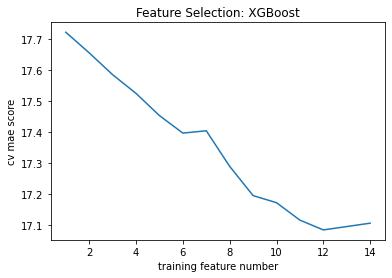

In [ ]:
# feature selection 시각화
plt.plot(range(1,15), cv_mae_selected)
plt.title('Feature Selection: XGBoost')
plt.xlabel('training feature number')
plt.ylabel('cv mae score')
plt.show()

In [ ]:
print('Feature Selection of XGBoost', '\ncv mae score:', min(cv_mae_selected))

Feature Selection of XGBoost 
cv mae score: 17.08363


## Best Model
- xgboost
- 13개의 feature selection

# PCA

In [ ]:
X_train.shape

(9347, 14)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=14, svd_solver='full')
pc_X_train = pca.fit_transform(X_train)

In [ ]:
pc_X_train.shape

(9347, 14)

In [ ]:
# 중요도 높은 feature 순서대로 선택하여 훈련
cv_mae_selected = []
for i in tqdm(range(14)):
    pc_X_train_selected = pc_X_train[:,:i+1]
    kf = KFold(n_splits=5)
    scores = []
    for train_index, test_index in kf.split(pc_X_train_selected):
        svr = grid_svr.best_estimator_
        svr.fit(pc_X_train_selected[train_index], y_train[train_index])
        pred = svr.predict(pc_X_train_selected[test_index])
        scores.append(mae(y_train[test_index], pred))
    cv_mae = np.mean(scores)
    cv_mae_selected.append(cv_mae)
    print(i, 'fold')

  7%|▋         | 1/14 [01:20<17:27, 80.56s/it]

0 fold


 14%|█▍        | 2/14 [02:06<14:01, 70.15s/it]

1 fold


 21%|██▏       | 3/14 [02:40<10:52, 59.36s/it]

2 fold


 29%|██▊       | 4/14 [03:19<08:50, 53.09s/it]

3 fold


 36%|███▌      | 5/14 [03:55<07:12, 48.00s/it]

4 fold


 43%|████▎     | 6/14 [04:35<06:04, 45.58s/it]

5 fold


 50%|█████     | 7/14 [05:14<05:05, 43.58s/it]

6 fold


 57%|█████▋    | 8/14 [05:51<04:10, 41.83s/it]

7 fold


 64%|██████▍   | 9/14 [06:31<03:25, 41.19s/it]

8 fold


 71%|███████▏  | 10/14 [07:08<02:39, 39.95s/it]

9 fold


 79%|███████▊  | 11/14 [07:48<01:59, 39.82s/it]

10 fold


 86%|████████▌ | 12/14 [08:27<01:19, 39.68s/it]

11 fold


 93%|█████████▎| 13/14 [09:06<00:39, 39.36s/it]

12 fold


100%|██████████| 14/14 [09:45<00:00, 41.85s/it]

13 fold


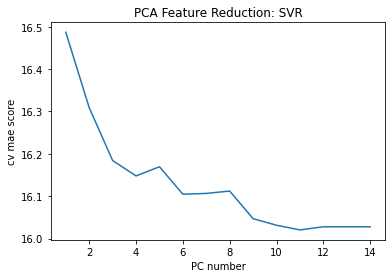

In [ ]:
plt.plot(range(1,15), cv_mae_selected)
plt.title('PCA Feature Reduction: SVR')
plt.xlabel('PC number')
plt.ylabel('cv mae score')
plt.show()

In [ ]:
print('Feature Selection of SVR', '\ncv mae score:', min(cv_mae_selected))

Feature Selection of SVR 
cv mae score: 16.020509257989527
